# Multidimensional Pattern identification with SAX
## Cross building/attribute slice

This script performs pattern identification over the {site, attribute} cuboid, which allows exploration of cross-building/attributes combined analysis within a fixed time slice of interested.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
# SAX package - source https://github.com/seninp/saxpy
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.paa import paa
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Plotting modules
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.rcdefaults()
# Plotly
import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.io as pio

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\cross_blgattrib_slice\\"

## Read

In [2]:
def reduce_mem_usage(df, verbose=True):
    """"Function to reduce the memory usage of a dataframe.
    Source: https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction"""

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
# Read Cuboid
timestamp = "2017-01-01"
df = pd.read_csv(path_data + "cuboid_C_2017-01-01.csv", header=[0,1])
# Drop first row - full of NaNs
df.drop(0, axis=0, inplace=True)

# Set & format index
df.set_index(df.columns.values[0], inplace=True)    # set
df.index.rename("timestamp", inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')

# Drop columns full of NaNs
df.dropna(axis=1, how='all', inplace=True)

# Reduce memory usage
df = reduce_mem_usage(df, verbose=True)
df.head()

Mem. usage decreased to  0.17 Mb (74.4% reduction)


electricity                         \
                    Bear_assembly_Angel Bear_assembly_Beatrice   
timestamp                                                        
2017-01-01 00:00:00             220.000                12.2500   
2017-01-01 01:00:00             215.125                 8.6250   
2017-01-01 02:00:00             209.250                 8.7500   
2017-01-01 03:00:00             209.000                 8.8125   
2017-01-01 04:00:00             213.500                 8.9375   

                                                              \
                    Bear_assembly_Danial Bear_assembly_Diana   
timestamp                                                      
2017-01-01 00:00:00             105.5625            0.645508   
2017-01-01 01:00:00              95.8750            0.687500   
2017-01-01 02:00:00              90.3125            0.685547   
2017-01-01 03:00:00              88.3750            0.757324   
2017-01-01 04:00:00              92.8750            0.790527   

                                                             \
                    Bear_assembly_Genia Bear_assembly_Harry   
timestamp                                                     
2017-01-01 00:00:00             208.875             12.3750   
2017-01-01 01:00:00             198.750             11.5625   
2017-01-01 02:00:00             188.000             11.5000   
2017-01-01 03:00:00             185.375             11.5625   
2017-01-01 04:00:00             185.375             11.8750   

                                                                              \
                    Bear_assembly_Jose Bear_assembly_Roxy Bear_assembly_Ruby   
timestamp                                                                      
2017-01-01 00:00:00            158.375             9.0000            48.1250   
2017-01-01 01:00:00            154.875             9.0000            48.1875   
2017-01-01 02:00:00            147.625             9.0000            48.3125   
2017-01-01 03:00:00            146.750             8.9375            48.3750   
2017-01-01 04:00:00            148.500             8.9375            48.2500   

                                            ...      seaLvlPressure  \
                    Bear_education_Alfredo  ... Swan_unknown_Jerold   
timestamp                                   ...                       
2017-01-01 00:00:00               0.090637  ...              1015.5   
2017-01-01 01:00:00               0.093750  ...              1015.0   
2017-01-01 02:00:00               0.093140  ...              1015.5   
2017-01-01 03:00:00               0.092529  ...              1016.0   
2017-01-01 04:00:00               0.090027  ...              1015.5   

                                                             \
                    Swan_unknown_Noelia Swan_unknown_Raquel   
timestamp                                                     
2017-01-01 00:00:00              1015.5              1015.5   
2017-01-01 01:00:00              1015.0              1015.0   
2017-01-01 02:00:00              1015.5              1015.5   
2017-01-01 03:00:00              1016.0              1016.0   
2017-01-01 04:00:00              1015.5              1015.5   

                                                                             \
                    Swan_unknown_Reyna Swan_unknown_Rocco Swan_unknown_Rudy   
timestamp                                                                     
2017-01-01 00:00:00             1015.5             1015.5            1015.5   
2017-01-01 01:00:00             1015.0             1015.0            1015.0   
2017-01-01 02:00:00             1015.5             1015.5            1015.5   
2017-01-01 03:00:00             1016.0             1016.0            1016.0   
2017-01-01 04:00:00             1015.5             1015.5            1015.5   

                                                                              \
                    Swan_unknown_Tom Swan_unknown_Val

## Pre-Mining transformation functions

In [3]:
def multicol_2ndColumnSelection(df_multicol, allcol1, col2):
    """"Function to select data from a multi-column dataframe based on the 2nd column value.
    From a defined 2nd-level column of interest - col2,
     the function loops over the dataframe from all the values interest from the 1st-level column - allcol1"""
    df = pd.DataFrame()
    for i in allcol1:
        df[i] = df_multicol[i, col2].copy()
    return df

def multi2singlecol_1stCol(df_in):
    """"Function to transform a 2 column dataframe to a single one, while appending the 2nd column information
    to a new attribute."""
    # Extract upper level column meter_type information
    meter_type_list = []
    for meter_type, blg_id in df_in.columns.values:
        meter_type_list.append(meter_type)
    meter_type_list = list(set(meter_type_list))

    dfs = []
    for i in meter_type_list:
        df1 = pd.melt(df_in[i].reset_index(),
                      id_vars=df_in.index.name,
                      var_name="building_id",
                      value_name=i)
        df1.set_index(["building_id", df_in.index.name], inplace=True)
        dfs.append(df1)  # append to list
    meter_df = pd.concat(dfs, axis=1)
    meter_df = meter_df.reset_index().set_index([df_in.index.name], drop=True)
    return meter_df

from sklearn.preprocessing import MinMaxScaler
def scale_NanRobust(data_array, scaler):
    """ A function to scale an array while being robust to outliers.
    Adapted from: https://stackoverflow.com/questions/55280054/handling-missing-nan-values-on-sklearn-preprocessing"""
    # Set valid mask
    nan_mask = np.isnan(data_array)
    valid_mask = ~nan_mask
    # create a result array
    result = np.full(data_array.shape, np.nan)
    # assign only valid cases to
    result[valid_mask] = scaler.fit_transform(data_array[valid_mask].reshape(-1, 1)).reshape(data_array[valid_mask].shape)
    return result

def scale_df_columns_NanRobust(df_in, target_columns, scaler=MinMaxScaler(feature_range=(1, 2))):
    """"A function to normalize columns of a dataframe per column, while being robust to Nan values.
    The function returns a similar dataframe with missing values in identical places - normalized with the scaler object."""
    # Identify target from non-target column values
    nontarget_columns = list(set(df_in.columns) - set(target_columns))
    df = df_in[target_columns].copy()
    # Scale over the target columns
    array_scaled = []
    for col in df.columns:
        array_scaled.append(scale_NanRobust(df[col].values, scaler))
    df_scaled = pd.DataFrame(np.vstack(array_scaled).transpose(), columns=df.columns)
    # Set scaled dataframe index
    df_scaled[df_in.index.name] = df_in.index
    df_scaled.set_index([df_in.index.name], inplace=True, drop=True)
    # Merge non-target columns to the scaled frame
    df_scaled[nontarget_columns] = df_in[nontarget_columns]
    return df_scaled

def checkIfExists(elem):
    if elem:
        return elem
    else:
        return ['None']

def flatten_list(l):
    for el in l:
        if isinstance(el, list):
            yield from flatten_list(el)
        else:
            yield el

## SAX functions

In [4]:
def SAX_mining(df_in, W=4, A=3):
    """"Function to perform daily SAX mining on input dataframe"""
    # Input definition of the function
    df_sax = df_in.copy()
    df_sax['Day'] = df_sax.index.dayofyear
    df_sax['Hour'] = df_sax.index.hour

    # Daily SAX over the year with reduced daily size
    sax_dict, counts, sax_data = dict(), dict(), dict()
    for meter in df_in.columns.values:
        # Daily heatmaps over all year
        sax_data[meter] = pd.pivot_table(df_sax, values=meter,
                                  index=['Day'], columns='Hour')
        sax_data[meter] = reduce_mem_usage(sax_data[meter], verbose=False)

        # Daily SAX obtained here with hourly resolution
        daily_sax = []
        for i in range(sax_data[meter].shape[0]):
            dat_paa = paa(sax_data[meter].values[i], W)
            daily_sax.append(ts_to_string(dat_paa, cuts_for_asize(A)))
        sax_dict[meter] = daily_sax

        # Now count the number of similar elements in the SAX list
        counts[meter] = Counter(sax_dict[meter])
    return sax_dict, counts, sax_data

def counter_plot(counter, title=None):
    """Simple demo of a horizontal bar chart.
    Source: https://stackoverflow.com/questions/22222573/how-to-plot-counter-object-in-horizontal-bar-chart"""
    # Sort the counter dictionnary per value
    # source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1])}
    # Counter data, counter is your counter object
    keys = counter.keys()
    y_pos = np.arange(len(keys))
    # get the counts for each key, assuming the values are numerical
    performance = [counter[k] for k in keys]
    # Now plotting
    fig = plt.figure(figsize=(6, 6))
    plt.barh(y_pos, performance, align='center', alpha=0.4)
    plt.yticks(y_pos, keys)
    plt.xlabel('Number of profiles per symbolic sequence')
    plt.title(title)
    plt.show()
    return fig

def SAXannotated_heatmap_viz(df_in, df_text, title):
    fig = ff.create_annotated_heatmap(z=df_in.values.tolist(),
                                      x=df_in.columns.values.tolist(),
                                      y=df_in.index.values.tolist(),
                                      annotation_text=df_text,
                                      colorbar={"title": "Counts"},
                                      colorscale='Blues')
    p_height = len(df_in.index)*15 if len(df_in.index)*15 > 400 else 400
    p_width = len(df_in.columns)*120 if len(df_in.columns)*120 > 400 else 400
    fig.update_layout(height=p_height, width=p_width,
                      xaxis={"tickmode": "array"},
                      #title_text=f" Daily SAX for time slice: {title}",
                      plot_bgcolor='#fff'
                      )
    fig.show()
    return fig

## Clustering & visualization functions

In [5]:
def elbow_wcss(X, n_cluster_max):
    """"Within Cluster Sum of Squares (WCSS) method for optimal number of clusters identification"""
    wcss, sil = [], []  # Within Cluster Sum of Squares (WCSS) & silhouette index
    for i in range(2, n_cluster_max):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans_pred_y = kmeans.fit_predict(X)
        wcss.append(kmeans.inertia_)  # WCSS
        sil.append(metrics.silhouette_score(X, kmeans_pred_y, metric="euclidean"))  # Silhouette score
    return wcss, sil

def similarity_index_plot(wcss, sil):
    fig, axs = plt.subplots(2, 1, sharex=True)
    axs[0].scatter(range(2,len(sil)+2),sil,
                   c='c', marker='v')
    axs[1].scatter(range(2,len(wcss)+2),wcss,
                   c='r', marker='o')
    # Legend
    axs[0].set_ylabel('Silhouette')
    axs[1].set_ylabel('Cluster Sum of Squares')
    axs[1].set_xlabel('cluster number')
    # Set ticks inside
    plt.xticks(range(2,len(sil)+2), range(2,len(sil)+2))
    axs[0].tick_params(axis="y", direction="in", left="off", labelleft="on")
    axs[0].tick_params(axis="x", direction="in", left="off", labelleft="on")
    axs[1].tick_params(axis="x", direction="in", left="off", labelleft="on")
    axs[1].tick_params(axis="y", direction="in", left="off", labelleft="on")
    axs[0].grid(axis='y', color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
    axs[1].grid(axis='y', color='grey', linestyle='--', linewidth=0.5, alpha=0.4)
    fig.tight_layout()
    plt.show()
    return fig

def cluster_counter_plot(counts, title=None):
    """Plot motif counts per cluster with whiskers"""
    stats = counts.describe()
    stats = stats.transpose().sort_values(by=['50%'], ascending=False).transpose()
    keys = counts.columns
    y_pos = np.arange(len(keys))
    yerr_pos = stats.loc['75%'].values - stats.loc['50%'].values
    yerr_neg = stats.loc['50%'].values - stats.loc['25%'].values
    # Now plotting
    fig = plt.figure(figsize=(6, 4))
    ax = plt.gca()
    plt.bar(y_pos,
             stats.loc['50%'].values,
             #yerr=stats.loc[['75%','25%']].values,          # Define error bar as the difference between 50% and quantiles
             yerr = [yerr_neg, yerr_pos],
             tick_label=keys,
             align='center',
             alpha=0.4)
    hfont = {'fontname': 'Times New Roman'}
    ax.tick_params(axis="y", direction="in", left="off", labelleft="on", labelsize=13)
    ax.tick_params(axis="x", direction="in", left="off", labelleft="on", labelsize=13)
    plt.xticks(y_pos, keys, rotation=90, **hfont)
    plt.yticks(**hfont)
    #plt.xlabel('Symbolic Aggregate Approximation sequences', **hfont)
    plt.ylabel('counts', fontsize=15, **hfont)
    plt.title(title, **hfont)
    plt.tight_layout()
    plt.show()
    return fig

In [113]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    """Wrapper function for Sankey Diagram.
    Source: https://medium.com/kenlok/how-to-create-sankey-diagrams-from-dataframes-in-python-e221c1b4d6b0"""
  
    # maximum of 6 value cols -> 6 colors
    colorPalette = sns.color_palette("Spectral", len(cat_cols)).as_hex()
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

def SAXannotated_hm_wcounts(df_olap_normalized, df_text, title):
    """Heatmap annoted plot with counts per groupby object"""

    # Per unique sax: get building list
    group_len, group_oneblg, group_name = [], [], []
    for name, group in df_text.groupby(df_text.columns.values.tolist()):
        group_len.append(len(group.index.tolist()))
        group_oneblg.append(group.index.tolist()[0])
        group_name.append(name)
    # Drop row duplicates
    df_olap_norm_reduced = df_olap_normalized[df_text.columns.values.tolist()].loc[group_oneblg]

    # Heatmap
    fig1 = ff.create_annotated_heatmap(z=df_olap_norm_reduced.values.tolist(),
                                    x=df_olap_norm_reduced.columns.values.tolist(),
                                    y=df_olap_norm_reduced.index.values.tolist(),
                                    annotation_text=group_name,
                                    colorbar={"title": "Counts"},
                                    colorscale='Blues')
    p_height = len(df_in.index)*15 if len(df_in.index)*15 > 400 else 400
    p_width = len(df_in.columns)*120 if len(df_in.columns)*120 > 400 else 400
    fig1.update_layout(height=p_height, width=p_width,
                        xaxis={"tickmode": "array"},
                        #title_text=f" Daily SAX for time slice: {title}",
                        plot_bgcolor='#fff')
    # Barplot
    fig2 = go.Figure(go.Bar(x=group_len,
                            y=df_olap_norm_reduced.index.values.tolist(),
                            orientation='h',
                            marker={'color': 'grey'}))
    # Edit layout for multiplot
    for i in range(len(fig1.data)):
        fig1.data[i].xaxis='x1'
        fig1.data[i].yaxis='y1'
    fig1.layout.yaxis1.update({'anchor': 'x1'})
    fig1.layout.xaxis1.update({'anchor': 'y1', 'domain': [0, .75]})
    for i in range(len(fig2.data)):
        fig2.data[i].xaxis='x2'
        fig2.data[i].yaxis='y2'
    # Initialize xaxis2 and yaxis2
    fig2['layout']['xaxis2'] = {}
    fig2['layout']['yaxis2'] = {}
    fig2.layout.yaxis2.update({'anchor': 'x2', 'showticklabels': False})
    fig2.layout.xaxis2.update({'anchor': 'y2', 'domain': [.76, 1]})
    # Multi plot
    fig = go.Figure()
    fig.add_traces([fig1.data[0], fig2.data[0]])
    fig.layout.update(fig1.layout)
    fig.layout.update(fig2.layout)
    # Figure size
    png_renderer = pio.renderers["png"]
    png_renderer.width = 800
    png_renderer.height = 800
    pio.renderers.default = "png"
    fig.show()
    return fig

## Cross building/attribute sequence identification

In [9]:
# Timerange definition
start_date = df.index.values[0]
end_date = df.index.values[-1]

### OLAP
# Daily averaging
df_d = df.copy().resample('D').mean()
df_d = df_d.transpose().reset_index()
df_d.columns = ["meter", "building_id", "value"]
df_olap = df_d.pivot(index="meter", columns="building_id", values="value")
df_olap = df_olap.dropna(axis=1, how='all').transpose()

# Normalize per column (attribute)
scaler_function = MinMaxScaler() #StandardScaler()
df_olap_normalized = scale_df_columns_NanRobust(df_olap, target_columns=df_olap.columns, scaler=scaler_function)
df_olap_normalized.head()

meter                   airTemperature  chilledwater  electricity  gas  \
building_id                                                              
Bear_assembly_Angel                NaN           NaN     0.207382  NaN   
Bear_assembly_Beatrice             NaN           NaN     0.010113  NaN   
Bear_assembly_Danial               NaN           NaN     0.041239  NaN   
Bear_assembly_Diana                NaN           NaN     0.000269  NaN   
Bear_assembly_Genia                NaN           NaN     0.074106  NaN   

meter                   hotwater  seaLvlPressure  
building_id                                       
Bear_assembly_Angel          NaN             NaN  
Bear_assembly_Beatrice       NaN             NaN  
Bear_assembly_Danial         NaN             NaN  
Bear_assembly_Diana          NaN             NaN  
Bear_assembly_Genia          NaN             NaN

In [10]:
### OLAM
# Data manipulation to get daily SAX
df_sax = multi2singlecol_1stCol(df)

# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per column (here attribute) robust to Nans
columns_considered = ["electricity", "gas", "hotwater", "chilledwater","airTemperature", "seaLvlPressure"]
#columns_considered = [col for col in df_sax.columns if col not in ['building_id', 'timestamp']]
df_sax_normalized = scale_df_columns_NanRobust(df_sax, target_columns=columns_considered, scaler=scaler_function)

# Now loop over unmerged column to perform SAX
sax_dict, counts, sax_data = dict(), dict(), dict()
dfs = []
for blg in df_sax_normalized['building_id'].unique():
    sax_dict[blg], counts[blg], sax_data[blg] = SAX_mining(df_sax_normalized[columns_considered][df_sax_normalized['building_id'] == blg],
                                                           W=day_number_of_pieces, A=alphabet_size)
    # Append the results to a list
    dfs.append(pd.DataFrame(sax_dict[blg].items(), columns=['Meter', blg]).set_index('Meter'))
# Concatenate the list to a common dataframe
df_sax_dict = pd.concat(dfs, axis=1)

# Post-processing
for col in df_sax_dict.columns:
    df_sax_dict[col] = list(flatten_list([[subitem for subitem in checkIfExists(item)] for item in df_sax_dict[col].values]))

In [11]:
## Visualize cross-building/attribute SAX heatmap

# Pivoting the dataframe for plotting
df_olap_normalized = df_olap_normalized.reindex(columns=columns_considered)
text_list = df_sax_dict.transpose().reindex(columns=columns_considered).values.tolist()
# Plot Heatmap
fig = SAXannotated_heatmap_viz(df_olap_normalized, text_list, timestamp)
fig.write_image(path_fig_out+"cross_blgattrib_SAX_timeslice_"+timestamp+"_"+version+".png")

ValueError: 
For some reason plotly.py was unable to communicate with the
local orca server process, even though the server process seems to be running.

Please review the process and connection information below:

orca status
-----------
    state: running
    executable: C:\Users\20190285\AppData\Local\Continuum\anaconda3\orca.CMD
    version: 1.3.1
    port: 60044
    pid: 27568
    command: ['C:\\Users\\20190285\\AppData\\Local\\Continuum\\anaconda3\\orca.CMD', 'serve', '-p', '60044', '--plotly', 'C:\\Users\\20190285\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\plotly\\package_data\\plotly.min.js', '--graph-only', '--mathjax', 'https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js']




## Cross building clustering from multi-attribute
Buildings are clustered together from an within time slice view of the data cube. This time multi-attributes are used with clustering leveraging high-dimensional similarity metrics. Here notions of motifs and discords cannot be exploited as a result of the limited time-slice view only.

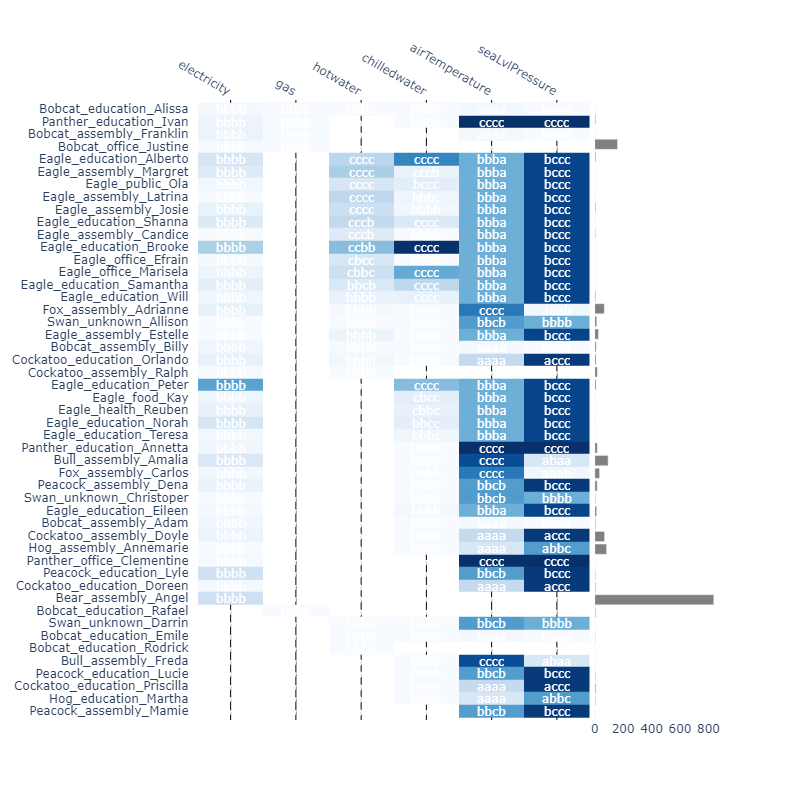

In [115]:
## Cross-building/attribute SAX counts heatmap

# Pivoting & reindexing the dataframe for plotting
df_text = df_sax_dict.transpose().reindex(columns=columns_considered)
df_olap_normalized = df_olap_normalized.reindex(columns=columns_considered)

# Heatmap with count plot
fig = SAXannotated_hm_wcounts(df_olap_normalized, df_text, timestamp)
fig.write_image(path_fig_out+"cross_blgattrib_SAX_timeslice_"+timestamp+"_reducedwcounts_"+version+".png")

### Sankey Diagram of cross attribute counts

In [103]:
# Counting duplicates 
dups = df_text.pivot_table(index = df_text.columns.values.tolist(), aggfunc ='size')  
dups.head(10)

electricity  gas   hotwater  chilledwater  airTemperature  seaLvlPressure
None         None  None      None          bbcb            bccc                2
                             bbbb          aaaa            abbc                4
                                                           accc                7
                                           bbcb            bccc                4
                                           cccc            abaa                1
                   bbbb      None          None            None                1
                             bbbb          aaaa            baaa                3
                                           bbcb            bbbb                2
             bbbb  None      None          None            None                6
bbbb         None  None      None          None            None              837
dtype: int64

In [98]:
# Formating counts for Snkey ploting
df_dups = pd.DataFrame(dups).reset_index().rename(columns = {0:'count'})
# Creating unique attribute_sequence values
for col in columns_considered:
    df_dups[col] = [col[0:4]+'_']*len(df_dups[col]) + df_dups[col]
# Sorting the frame
df_dups.sort_values(by=['count'], ascending=False, inplace=True)
df_dups.reset_index(inplace=True, drop=True)
df_dups.head()

electricity       gas   hotwater chilledwater airTemperature seaLvlPressure  \
0   elec_bbbb  gas_None  hotw_None    chil_None      airT_None      seaL_None   
1   elec_bbbb  gas_bbbb  hotw_None    chil_None      airT_None      seaL_None   
2   elec_bbbb  gas_None  hotw_None    chil_bbbb      airT_cccc      seaL_abaa   
3   elec_bbbb  gas_None  hotw_None    chil_bbbb      airT_aaaa      seaL_abbc   
4   elec_bbbb  gas_None  hotw_None    chil_bbbb      airT_aaaa      seaL_accc   

   count  
0    837  
1    160  
2     94  
3     83  
4     69

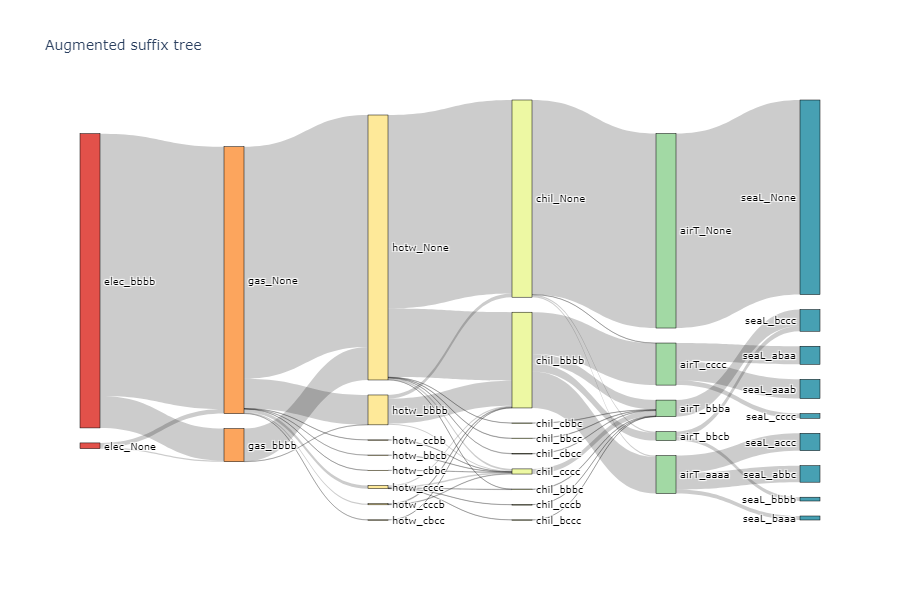

In [99]:
fig = genSankey(df_dups,cat_cols=columns_considered,value_cols='count',title='Augmented suffix tree')
# Plot size & format
png_renderer = pio.renderers["png"]
png_renderer.width = 900
png_renderer.height = 600
pio.renderers.default = "png"
# Inline plot
fig_plt = go.Figure(fig)
fig_plt.show()
# # Offline plot
# plotly.offline.plot(fig, validate=False)

Lets filter out building groups with fewer than 5 similar sequence counts

In [61]:
# Obtain list of unique sax sequences
list_unique_sax = df_text_reduced.values.tolist()
# Per unique sax: get building list
group_dic = dict()
for name, group in df_text.groupby(df_text.columns.values.tolist()):
    if len(group.index.tolist()) >= 5:
        group_dic[name] = group.index.tolist()


group_name, group_blgs = [], []
for name, group in df_text.groupby(df_text.columns.values.tolist()):
    if len(group.index.tolist()) >= 5:
        group_name.append(name)
        group_blgs.append(group.index.tolist())


# Drop row duplicates
df_olap_norm_reduced = df_olap_normalized[df_text.columns.values.tolist()].loc[group_oneblg]

In [152]:
for name, group in df_text.groupby(df_text.columns.values.tolist()):
    #df_text_group.index = group.index.tolist()[0] if df_text_group.loc[name.tolist()]
    #df_text_group[df_text_group.values == name].index

    # Identify building index from SAX sequences:
    for row in range(len(df_text_group.index)):
        if (df_text_group[columns_considered].values[row] == name).all():
            df_text_group[columns_considered].loc[row].index.value = group.index.tolist()[0]

In [186]:
#Groupby Object to identify SAX sequence duplicates in cuboid slice
df_text_groupby = df_text.groupby(df_text.columns.values.tolist())
df_text_group = df_text_groupby.size().reset_index()

# Identifying building index list from groupby object with get_group()
index = []
for name, group in df_text_groupby:
    index.append(df_text_groupby.get_group(name).index[0])
# Adding building_id as a new column
df_text_group['building_id'] = index
# Set New Index
df_text_group.set_index('building_id', drop=True, inplace=True)
# Dataframe of groupby counts without building index
df_text_group = df_text_group.rename(columns = {0:'count'})
df_text_group.sort_values(by=['count'], ascending=False, inplace=True)

df_text_group.head()

electricity   gas hotwater chilledwater  \
building_id                                                       
Bear_assembly_Angel            bbbb  None     None         None   
Bobcat_office_Justine          bbbb  bbbb     None         None   
Bull_assembly_Amalia           bbbb  None     None         bbbb   
Hog_assembly_Annemarie         bbbb  None     None         bbbb   
Cockatoo_assembly_Doyle        bbbb  None     None         bbbb   

                        airTemperature seaLvlPressure  count  
building_id                                                   
Bear_assembly_Angel               None           None    837  
Bobcat_office_Justine             None           None    160  
Bull_assembly_Amalia              cccc           abaa     94  
Hog_assembly_Annemarie            aaaa           abbc     83  
Cockatoo_assembly_Doyle           aaaa           accc     69